In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from nonlinear import initial_distribution, transition_model, observation_model
from filters import ensemble_kf, bootstrap_pf, log_likelihood

save_figures = False

### 2.b
#### b.1

In [2]:
# Data
n_steps = 500

# conditional distribution ~ N(phi * u, sigma^2)
phi = 0.98
sigma2 = 0.16

# observation noise ~ N(0, beta^2 * exp(u))
beta2 = 0.7

# dynamical system parameters
p0 = initial_distribution(phi, sigma2)
p = transition_model(phi, sigma2)
nu = observation_model(beta2)

In [3]:
np.random.seed(566)
y = pd.read_csv('synthetic_data.csv')['y'].array
y = y.insert(0, 0.)

In [4]:
ns = [2 ** 7, 2 ** 12]  # values of number of particles to try

In [5]:
mean_en = []
std_en = []

for n_particles in ns:
    u_en = ensemble_kf(y, n_particles, p0, p, nu)

    mean_en.append(np.mean(u_en, axis=1))
    std_en.append(u_en.std(axis=1))

In [6]:
mse_bs = []
mean_bs = []
std_bs = []
ess_bs = []
ess_bs_no_resampling = []

for n_particles in ns:
    u_bs, w_bs, ess = bootstrap_pf(y, n_particles, p0, p, nu)

    mean = (w_bs * u_bs).sum(axis=1)
    std = (w_bs * (u_bs - mean[:, np.newaxis]) ** 2).sum(axis=1) ** 0.5

    mean_bs.append(mean)
    std_bs.append(std)
    ess_bs.append(ess)

    _, _, ess_no_resampling = bootstrap_pf(y, n_particles, p0, p, nu, no_resampling=True)
    ess_bs_no_resampling.append(ess_no_resampling)

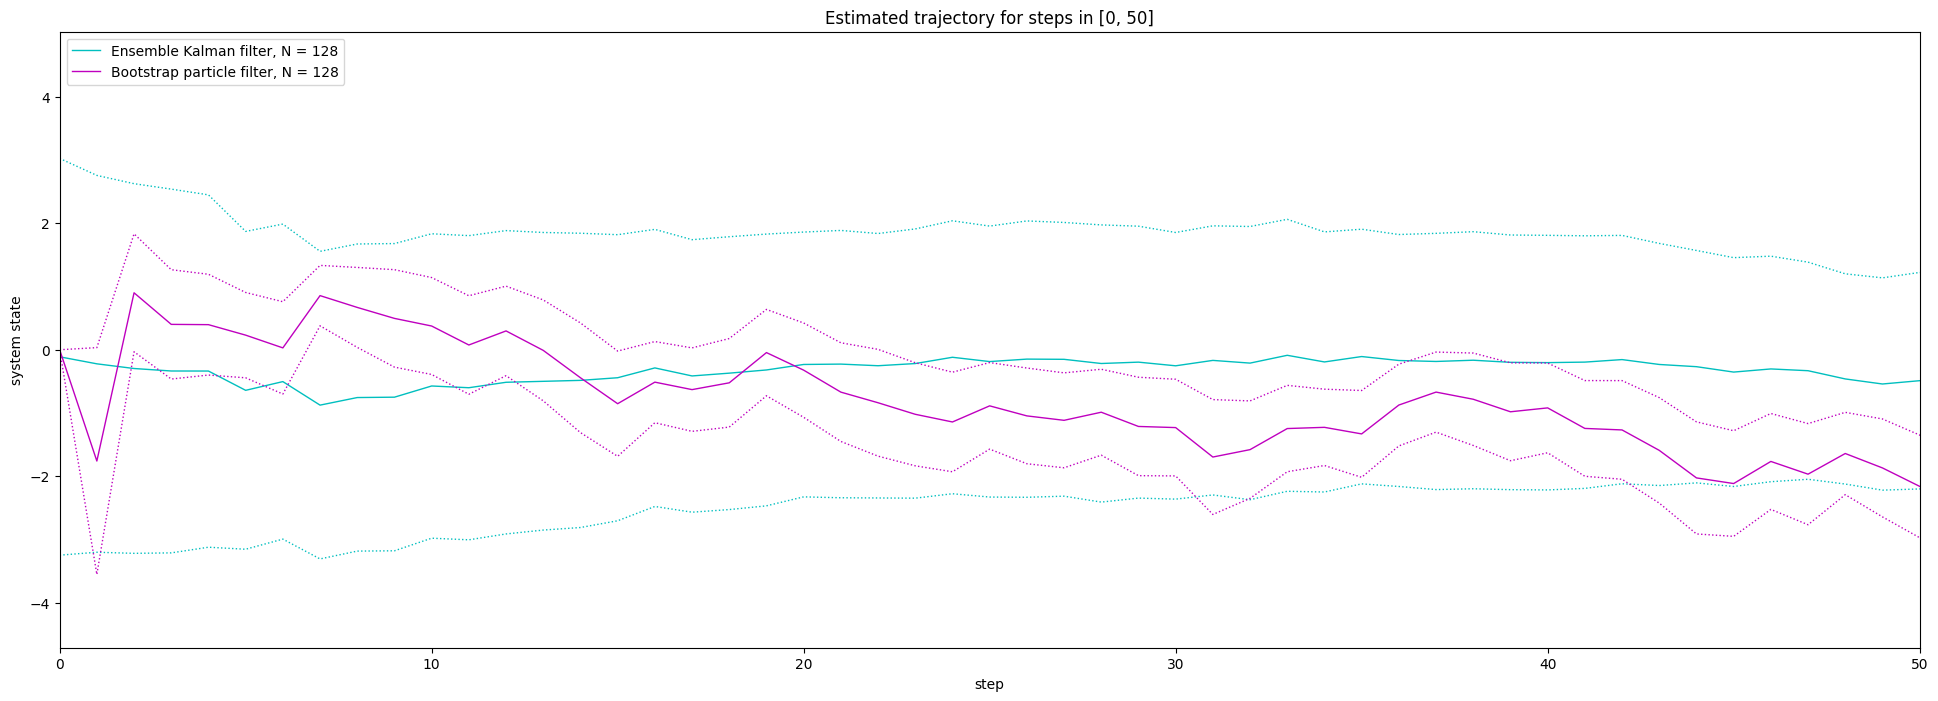

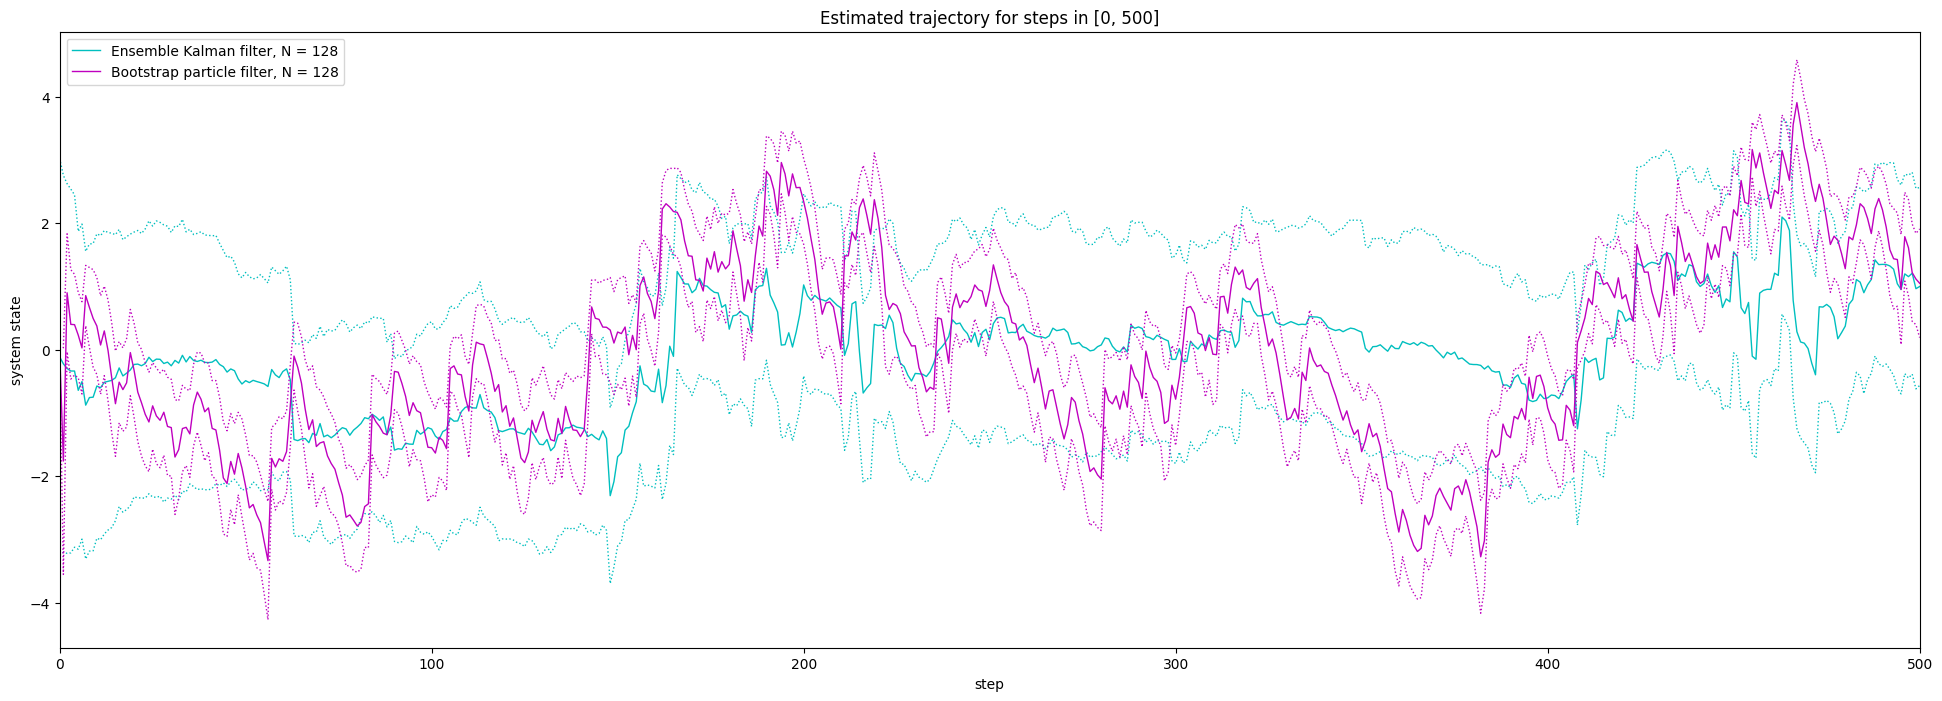

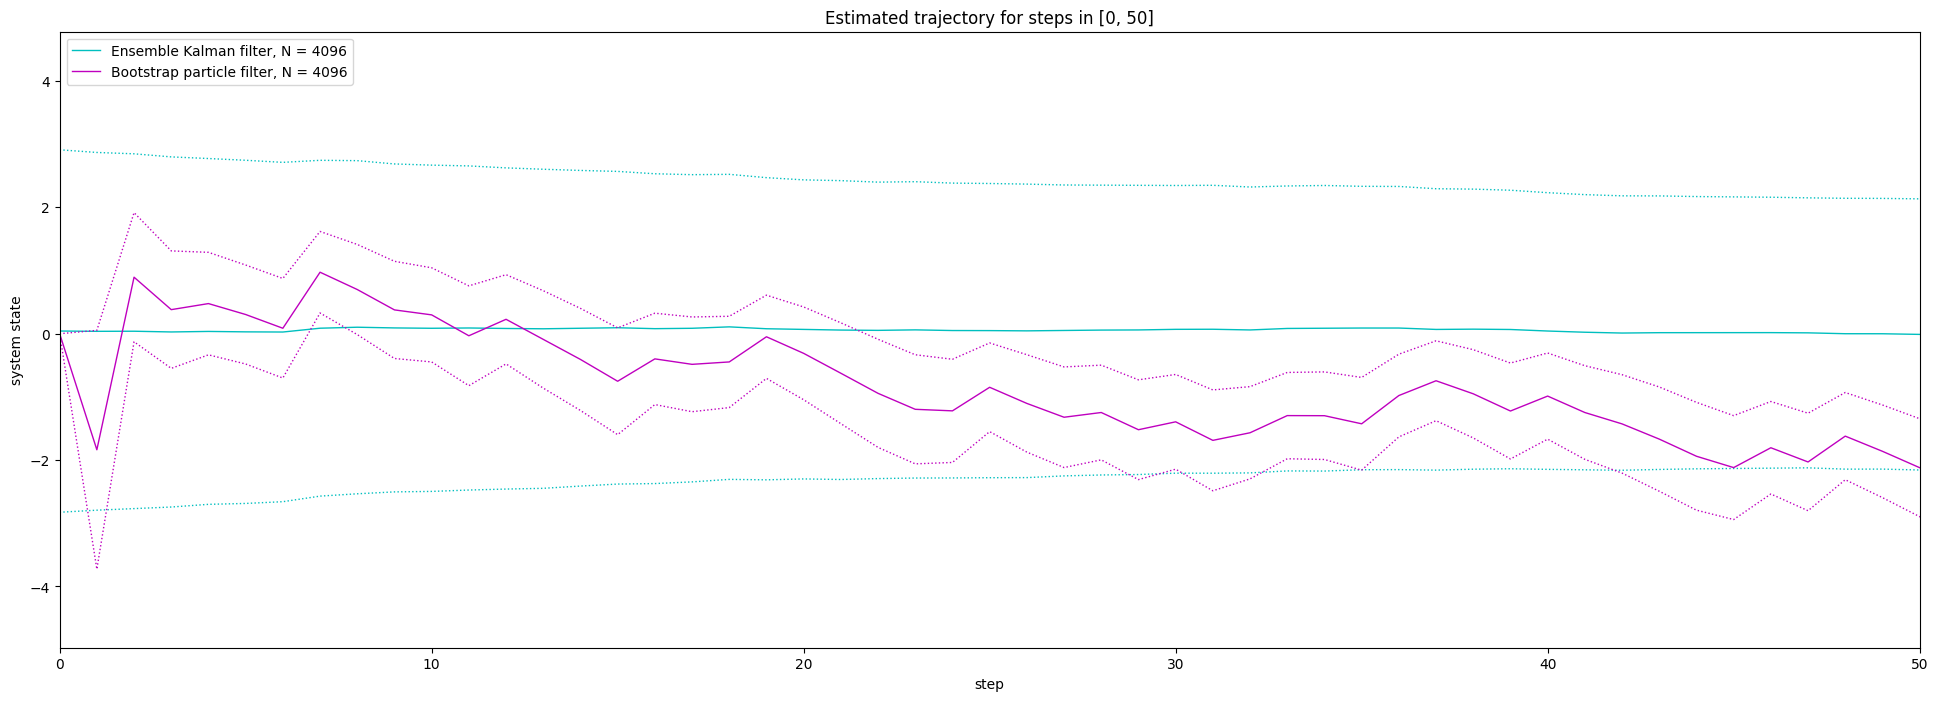

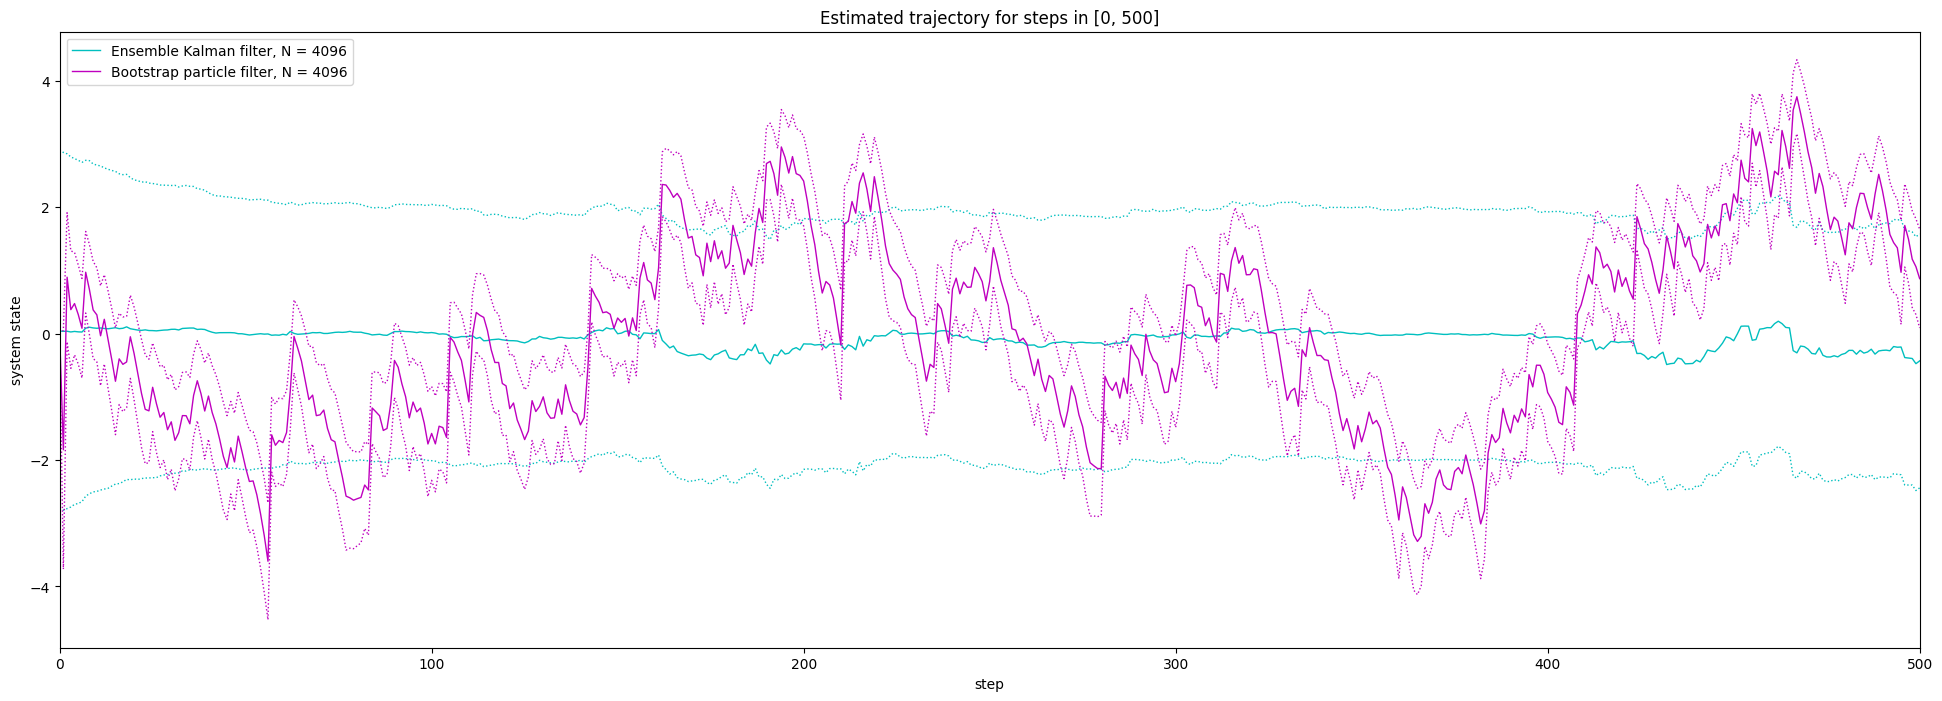

In [7]:
for i in [0, len(ns) - 1]:
    for xlim_left, xlim_right in [[0, n_steps // 10], [0, n_steps]]:
        plt.figure(figsize=(24, 8))

        plt.plot(mean_en[i], 'c', label=f'Ensemble Kalman filter, N = {ns[i]}', linewidth=1)
        plt.plot((mean_en[i] - std_en[i]), 'c:', linewidth=1)
        plt.plot((mean_en[i] + std_en[i]), 'c:', linewidth=1)

        plt.plot(mean_bs[i], 'm', label=f'Bootstrap particle filter, N = {ns[i]}', linewidth=1)
        plt.plot((mean_bs[i] - std_bs[i]), 'm:', linewidth=1)
        plt.plot((mean_bs[i] + std_bs[i]), 'm:', linewidth=1)

        plt.xlabel('step')
        plt.ylabel('system state')
        plt.title(f'Estimated trajectory for steps in [{xlim_left}, {xlim_right}]')
        plt.xlim(xlim_left, xlim_right)
        plt.legend(loc='upper left')

        if save_figures:
            plt.savefig(f'figures/b1_trajectories_{ns[i]}_{xlim_right}.png')
        plt.show()

#### b.2

In [8]:
n_particles = 2 ** 5
n_candidates = 21
n_estimates = 10

log_ls = np.zeros((n_candidates, n_estimates))
phi_candidates = np.linspace(0, 1, n_candidates)

for i in range(n_candidates):
    p_candidate = transition_model(phi_candidates[i], sigma2)

    for j in range(n_estimates):
        u_bs, _, _ = bootstrap_pf(y, n_particles, p0, p_candidate, nu)
        log_ls[i, j] = log_likelihood(u_bs, y, nu)

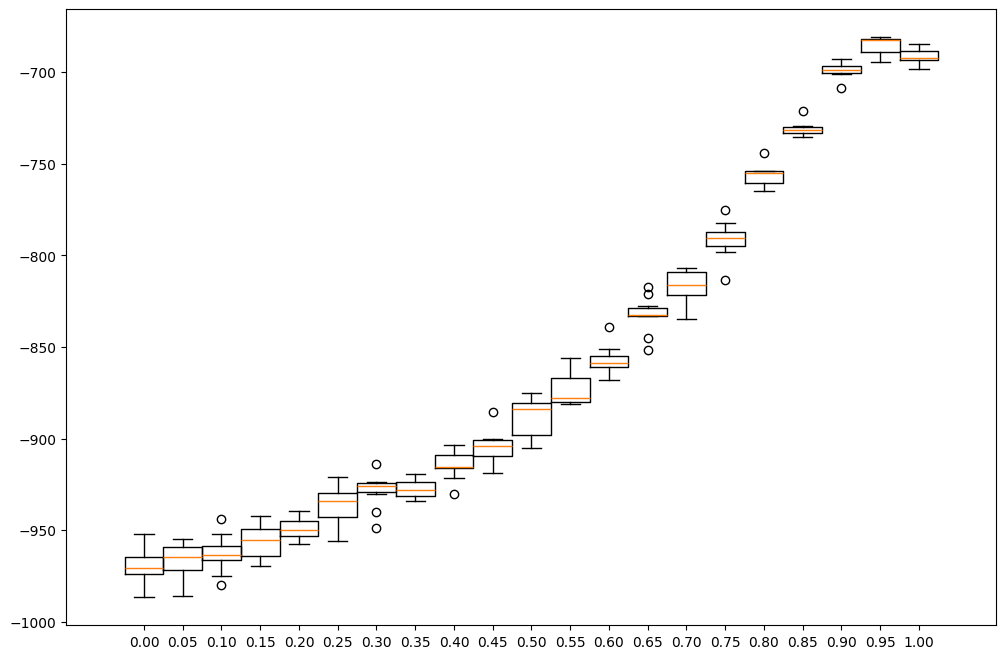

In [9]:
plt.figure(figsize=(12, 8))
plt.boxplot(log_ls.T, positions=phi_candidates, widths=0.05)
plt.xticks(phi_candidates, [f"{x:.2f}" for x in phi_candidates])
plt.xlim(-0.1, 1.1)

if save_figures:
    plt.savefig(f'figures/b2.png')
plt.show()